In [1]:
%%capture
%run "4 - Linear Algebra.ipynb"
%run "5 - Statistics.ipynb"
%run "6 - Probability.ipynb"
%run "8 - Gradient Descent.ipynb"

# Exploring Your Data
Before you start building models and looking for answers, you should explore the data.

## Exploring One-Dimensional Data
One-dimensional data is just a collection of some type, e.g., numbers.

A good place to start is with summary statistics.

In [2]:
def bucketize(point, bucket_size):
    """floor the point to the next lower multiple of bucket size"""
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points, bucket_size):
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points, bucket_size, title=''):
    histogram = make_histogram(points, bucket_size)
    plt.bar(list(histogram.keys()), histogram.values(), width=bucket_size, edgecolor='white')
    plt.title(title)
    plt.show()

In [3]:
import random

random.seed(0)

# uniform #'s will be between -100 and 100
uniform = [200 * random.random() - 100 for _ in range(10000)]

# normal #'s will be from the normal distribution with mean of 0 and standard deviation of 57
normal = [57 * inverse_normal_cdf(random.random()) for _ in range(10000)]

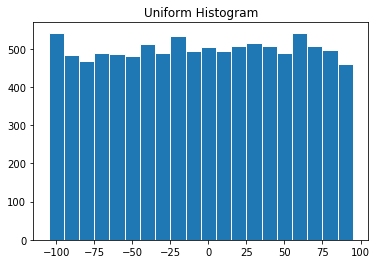

In [4]:
plot_histogram(uniform, 10, 'Uniform Histogram')

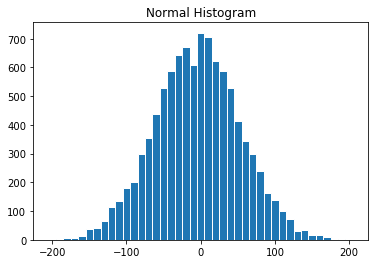

In [5]:
plot_histogram(normal, 10, 'Normal Histogram')

## Two Dimensions

In [73]:
def random_normal():
    """retuns random #'s from standard normal distribution"""
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)]
ys1 = [x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]
ys3 = [0 if x < 0 else 6 for x in xs]

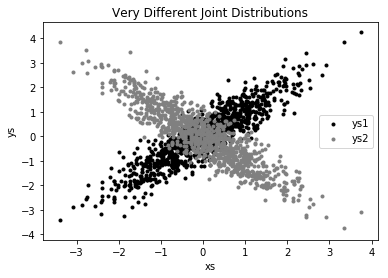

In [56]:
plt.scatter(xs, ys1, marker='.', color='black', label='ys1');
plt.scatter(xs, ys2, marker='.', color='gray', label='ys2');
plt.xlabel('xs');
plt.ylabel('ys');
plt.legend(loc=5);
plt.title('Very Different Joint Distributions');

In [57]:
correlation(xs, ys1), correlation(xs, ys2)

(0.9019487774302494, -0.8965212261021347)

## Many Dimensions
An easy way to investigate relationships between many dimensions is with a _correlation matrix_.

In [74]:
def correlation_matrix(data):
    """returns a matrix where x_ij is the correlation between col i and col j"""
    _, num_cols = shape(data)
    
    def matrix_entry(i, j):
        return correlation(get_column(data, i), get_column(data, j))
    
    return make_matrix(num_cols, num_cols, matrix_entry)

In [75]:
data = [[x, y2, y1, ys3] for (x, y1, y2, ys3) in zip(xs, ys1, ys2, ys3)]
correlation_matrix(data)

[[1.0, -0.8922735303889013, 0.8829716623768608, 0.8175309090847767],
 [-0.8922735303889013,
  1.0000000000000002,
  -0.7754356514861594,
  -0.7215613729574069],
 [0.8829716623768608,
  -0.7754356514861594,
  0.9999999999999998,
  0.7151824082856286],
 [0.8175309090847767,
  -0.7215613729574069,
  0.7151824082856286,
  0.9999999999999999]]

(-2.9753156350411594, 2.9879804299630335)

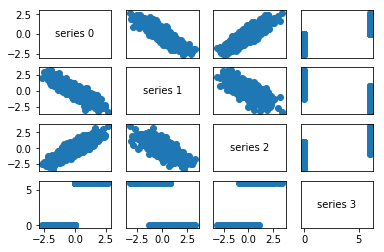

In [76]:
_, num_columns = shape(data)
fig, ax = plt.subplots(num_columns, num_columns)

for i in range(num_columns):
    for j in range(num_columns):
        # scatter column_j on the x-axis vs column_i on the y-axis
        if i != j: ax[i][j].scatter(get_column(data, j), get_column(data, i))
            
        # unless i == j, in which case show the series name
        else: ax[i][j].annotate("series " + str(i), (0.5, 0.5), xycoords='axes fraction', ha="center", va="center")
            
        # then hide axis labels except left and bottom charts
        if i < num_columns - 1: ax[i][j].xaxis.set_visible(False)
        if j > 0: ax[i][j].yaxis.set_visible(False)
        
# fix the bottom right and top left axis labels, which are wrong because
# their charts only have text in them
ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())

# Cleaning And Munging

In [77]:
def parse_row(input_row, parsers):
    """given a list of parsers (some of which may be None)
    apply the appropriate one to each element of the input_row"""
    return [parser(value) if parser is not None else value for value, parser in zip(input_row, parsers)]

def parse_rows_with(reader, parsers):
    """wrap a reader to apply the parsers to each of its rows"""
    for row in reader:
        yield parse_row(row, parsers)

In [78]:
def try_or_none(f):
    """wraps f to return None if f raises an exception
    assumes f takes only one input"""
    def f_or_none(x):
        try: return f(x)
        except: return None
    return f_or_none

In [79]:
def parse_row(input_row, parsers):
    return [try_or_none(parser)(value) if parser is not None else value for value, parser in zip(input_row, parsers)]

In [80]:
import dateutil.parser
import csv

data = []

with open("stocks.csv", "r") as f:
    reader = csv.reader(f)
    for line in parse_rows_with(reader, [dateutil.parser.parse, None, float]):
        data.append(line)
        
data

[[datetime.datetime(2014, 6, 20, 0, 0), 'AAPL', 90.91],
 [datetime.datetime(2014, 6, 20, 0, 0), 'MSFT', 41.68],
 [datetime.datetime(2014, 6, 20, 0, 0), 'FB', 64.5],
 [datetime.datetime(2014, 6, 21, 0, 0), 'AAPL', 91.28],
 [datetime.datetime(2014, 6, 21, 0, 0), 'MSFT', 40.37],
 [datetime.datetime(2014, 6, 21, 0, 0), 'FB', 64.92]]

# Manipulating Data

In [81]:
max_aapl_price = max(row[2]
                     for row in data
                     if row[1] == "AAPL")
max_aapl_price

91.28

# Rescaling
When working with data, many calculations are sensitive to the _scale_ of the data. Consider clustering as an example:

In [82]:
import pandas as pd

pd.DataFrame({'Height (inches)': [63, 67, 70], 'Height (centimeters)': [160, 170.2, 177.8], 'Weight': [150, 160, 171]}, index=['A', 'B', 'C'])

,Height (centimeters),Height (inches),Weight
A,160.0,63,150
B,170.2,67,160
C,177.8,70,171


If we use inches, B's closest neighbor is A:

In [83]:
a_to_b = distance([63, 150], [67, 160])
a_to_c = distance([63, 150], [70, 171])
b_to_c = distance([67, 160], [70, 171])

a_to_b, a_to_c, b_to_c

(10.770329614269007, 22.135943621178654, 11.40175425099138)

But if we use centimeters, the closest neighbor is C:

In [84]:
a_to_b = distance([160, 150], [170.2, 160])
a_to_c = distance([160, 150], [177.8, 171])
b_to_c = distance([170.2, 160], [177.8, 171])

a_to_b, a_to_c, b_to_c

(14.284257068535268, 27.52889391167034, 13.370115930686627)

When results are impacted by units of measure like in the above example, scaling can help. Rescaling projects values into a dimension with mean 0 and standard deviation 1. This effectively converts data into a common unit of "standard deviations from the mean."

In [20]:
def scale(data_matrix):
    """returns the means and standard deviations of each column"""
    num_rows, num_cols = shape(data_matrix)
    means = [mean(get_column(data_matrix,j)) for j in range(num_cols)]
    stdevs = [standard_deviation(get_column(data_matrix,j)) for j in range(num_cols)]
    
    return means, stdevs

In [21]:
def rescale(data_matrix):
    """rescales the input data so that each column
    has mean 0 and standard deviation 1
    leaves alone columns with no deviation"""
    means, stdevs = scale(data_matrix)
    
    def rescaled(i, j):
        if stdevs[j] > 0:
            return (data_matrix[i][j] - means[j]) / stdevs[j]
        else:
            return data_matrix[i][j]
    
    num_rows, num_cols = shape(data_matrix)
    return make_matrix(num_rows, num_cols, rescaled)

Rescale our weights so that they do not differ by units:

In [22]:
hts_in = [[63], [67], [70]]
hts_cm = [[160], [170.2], [177.8]]
wts = [[150], [160], [171]]

hts_in_rescaled = rescale(hts_in)
hts_cm_rescaled = rescale(hts_cm)
wts_rescaled = rescale(wts)

hts_in_rescaled, hts_cm_rescaled, wts_rescaled

([[-1.0440737953277504], [0.09491579957524855], [0.9491579957524977]],
 [[-1.0449798276855173], [0.09703384114222419], [0.9479459865432901]],
 [[-0.9837552647618352], [-0.03173404079876975], [1.0154893055606022]])

Now when we calculate distances, you can see that we end up with almost equivalent calculations for inches as we do centimeters:

In [23]:
a_to_b_rescaled = distance([hts_in_rescaled[0][0], wts_rescaled[0][0]], [hts_in_rescaled[1][0], wts_rescaled[1][0]])
a_to_c_rescaled = distance([hts_in_rescaled[0][0], wts_rescaled[0][0]], [hts_in_rescaled[2][0], wts_rescaled[2][0]])
b_to_c_rescaled = distance([hts_in_rescaled[1][0], wts_rescaled[1][0]], [hts_in_rescaled[2][0], wts_rescaled[2][0]])

a_to_b_rescaled, a_to_c_rescaled, b_to_c_rescaled

(1.4844668093876099, 2.823110310444266, 1.3514460651057634)

In [24]:
a_to_b_rescaled = distance([hts_cm_rescaled[0][0], wts_rescaled[0][0]], [hts_cm_rescaled[1][0], wts_rescaled[1][0]])
a_to_c_rescaled = distance([hts_cm_rescaled[0][0], wts_rescaled[0][0]], [hts_cm_rescaled[2][0], wts_rescaled[2][0]])
b_to_c_rescaled = distance([hts_cm_rescaled[1][0], wts_rescaled[1][0]], [hts_cm_rescaled[2][0], wts_rescaled[2][0]])

a_to_b_rescaled, a_to_c_rescaled, b_to_c_rescaled

(1.4867883610875934, 2.8228942865405537, 1.349343624267431)

# Dimensionality Reduction
On occasion, the actually useful dimension of the data might not correspond to the dimensions that we possess in the data. We can use _principal component analysis_ to extract one or more dimensions associated with as much of the variation as possible.

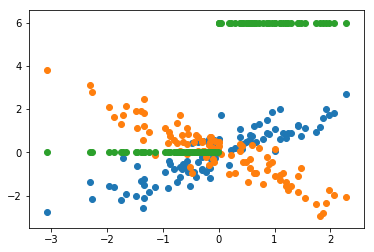

In [91]:
pca_data = [[7, 4, 3],
            [4, 1, 8],
            [6, 3, 5],
            [8, 6, 1],
            [8, 5, 7],
            [7, 2, 9],
            [5, 3, 3],
            [9, 5, 8],
            [7, 4, 5],
            [8, 2, 2]]
pca_xs = [random_normal() for _ in range(100)]
pca_ys1 = [x + random_normal() / 2 for x in pca_xs]
pca_ys2 = [-x + random_normal() / 2 for x in pca_xs]
pca_ys3 = [0 if x < 0 else 6 for x in pca_xs]
pca_data = [[x, y1, y2, y3] for (x, y1, y2, y3) in zip(pca_xs, pca_ys1, pca_ys2, pca_ys3)]

plt.scatter(pca_xs, pca_ys1);
plt.scatter(pca_xs, pca_ys2);
plt.scatter(pca_xs, pca_ys3);

In [93]:
def de_mean_matrix(A):
    """Returns each value in columns of A minus the mean of
    that column resulting in mean of 0 for all columns"""
    nr, nc = shape(A)
    column_means, _ = scale(A)
    return make_matrix(nr, nc, lambda i, j: A[i][j] - column_means[j])

pca_data_de_mean = de_mean_matrix(pca_data)
pca_data_de_mean[:5]

[[1.051360511779785, 1.1148850440979003, -1.1196836471557616, 3.36],
 [-1.7069326400756837, -2.1720202445983885, 1.2700620651245118, -2.64],
 [-0.44144496917724607, 0.493337345123291, -1.000417137145996, -2.64],
 [1.2427248001098632, 0.8720032691955566, -1.6006502151489257, 3.36],
 [0.03548755645751953, 0.11350793838500976, 0.16254100799560547, -2.64]]

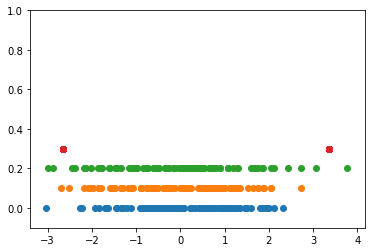

In [94]:
plt.scatter([x[0] for x in pca_data_de_mean], [0 for _ in pca_data_de_mean]);
plt.scatter([x[1] for x in pca_data_de_mean], [0.1 for _ in pca_data_de_mean]);
plt.scatter([x[2] for x in pca_data_de_mean], [0.2 for _ in pca_data_de_mean]);
plt.scatter([x[3] for x in pca_data_de_mean], [0.3 for _ in pca_data_de_mean]);
plt.ylim((-0.1, 1));

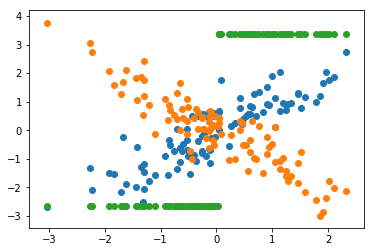

In [96]:
plt.scatter([x[0] for x in pca_data_de_mean], [x[1] for x in pca_data_de_mean]);
plt.scatter([x[0] for x in pca_data_de_mean], [x[2] for x in pca_data_de_mean]);
plt.scatter([x[0] for x in pca_data_de_mean], [x[3] for x in pca_data_de_mean]);

With the de-meaned matrix, we can figure out which direction captures the most variance in the data:

In [98]:
def direction(w):
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

pca_data_direction = [direction(w) for w in pca_data_de_mean]
pca_data_direction[:5]

[[0.2724461669952562,
  0.288907709107903,
  -0.29015120360422264,
  0.8706995467752567],
 [-0.42390836511502755,
  -0.5394105949275306,
  0.3154136964641298,
  -0.6556310762526939],
 [-0.15223426156033978,
  0.17012957826874203,
  -0.3449983004893647,
  -0.910415745066356],
 [0.3091734459389047,
  0.21694284654442125,
  -0.39822054143982066,
  0.8359234307248739],
 [0.01340330926062679,
  0.04287085822692894,
  0.061390177717843025,
  -0.9971026461180023]]

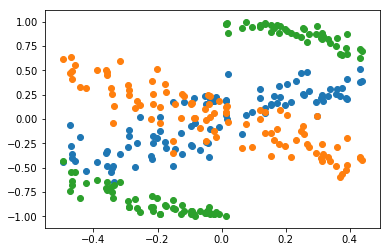

In [99]:
plt.scatter([x[0] for x in pca_data_direction], [x[1] for x in pca_data_direction]);
plt.scatter([x[0] for x in pca_data_direction], [x[2] for x in pca_data_direction]);
plt.scatter([x[0] for x in pca_data_direction], [x[3] for x in pca_data_direction]);

Now we can compute the variance of the data in the direction, w:

In [101]:
def directional_variance_i(x_i, w):
    """the variance of the row x_i in the direction determined by w"""
    return dot(x_i, direction(w)) ** 2

def directional_variance(X, w):
    """the variance of the data in the direction determined w"""
    return sum(directional_variance_i(x_i, w) for x_i in X)

def directional_variance_gradient_i(x_i, w):
    """the contribution of row x_i to the gradient of
    the direction-w variance"""
    projection_length = dot(x_i, direction(w))
    return [2 * projection_length * x_ij for x_ij in x_i]

def directional_variance_gradient(X, w):
    return vector_sum(directional_variance_gradient_i(x_i, w) for x_i in X)

pca_data_variance = [directional_variance(pca_data_direction, w) for w in pca_data_direction]
pca_data_variance[:5]

[87.65924913614802,
 73.00221139186546,
 52.683913177522065,
 85.13856399849642,
 74.72729464020203]

The _first principal component_ is the direction that maximizes the directional variance above.

In [102]:
def first_principal_component(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_batch(
        partial(directional_variance, X), # is now a function of w
        partial(directional_variance_gradient, X), # is now a function of w
        guess)
    return direction(unscaled_maximizer)

first_principal_component(pca_data)

[0.17329363243702403,
 0.17344648211991884,
 -0.17512059487460707,
 0.9535294500159761]

We can use stochastic gradient descent here:

In [103]:
def first_principal_component_sgd(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_stochastic(
        lambda x, _, w: directional_variance_i(x, w),
        lambda x, _, w: directional_variance_gradient_i(x, w),
        X,
        [None for _ in X], # the fake "y"
        guess)
    return direction(unscaled_maximizer)

first_principal_component_sgd(pca_data)

[0.5, 0.5, 0.5, 0.5]

In [104]:
def project(v, w):
    """returns the projection of v onto direction w"""
    projection_length = dot(v, w)
    return scalar_multiply(projection_length, w)

In [105]:
def remove_projection_from_vector(v, w):
    """projects v onto w and substracts the result from v"""
    return vector_subtract(v, project(v, w))

def remove_projection(X, w):
    return [remove_projection_from_vector(x_i, w) for x_i in X]

Given a three-dimensional data set, it becomes effectively two-dimensional when we remove the first component.

In [116]:
pca_data_fc_removed = remove_projection(pca_data, first_principal_component_sgd(pca_data))
pca_data_fc_removed[:5]

[[-0.7445731163024902,
  -0.6747593879699707,
  -2.8250374794006348,
  4.244369983673096],
 [-1.089003086090088,
  -1.5478014945983887,
  1.9785714149475098,
  0.6582331657409668],
 [-0.23860692977905273,
  0.7024645805358887,
  -0.7069993019104004,
  0.24314165115356445],
 [-0.4200878143310547,
  -0.784520149230957,
  -3.1728830337524414,
  4.377490997314453],
 [-0.0766897201538086,
  0.0076198577880859375,
  0.1409435272216797,
  -0.07187366485595703]]

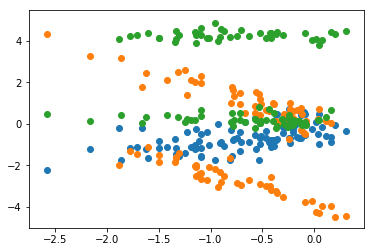

In [117]:
plt.scatter([x[0] for x in pca_data_fc_removed], [x[1] for x in pca_data_fc_removed]);
plt.scatter([x[0] for x in pca_data_fc_removed], [x[2] for x in pca_data_fc_removed]);
plt.scatter([x[0] for x in pca_data_fc_removed], [x[3] for x in pca_data_fc_removed]);

For higher-dimensional data sets, iterate to find as many components as you like:

In [118]:
def principal_component_analysis(X, num_components):
    components = []
    for _ in range(num_components):
        component = first_principal_component(X)
        components.append(component)
        X = remove_projection(X, component)
        
    return components

Then transform the data into a lower-dimensional space:

In [119]:
def transform_vector(v, components):
    return [dot(v, w) for w in components]

def transform(X, components):
    return [transform_vector(x_i, components) for x_i in X]

In [157]:
pca_components = principal_component_analysis(pca_data, 3)
pca_transformed = transform(pca_data, pca_components)
pca_transformed[:5]

[[6.271134902113677, -0.0659491636403704, 0.013015208706865039],
 [-0.9166322877126727, -2.834773131024607, -0.8655632340680965],
 [0.16257323366247278, 0.5883480998206554, -0.23766201937756126],
 [6.34639727683103, 0.21048505798788408, -0.48015230269225406],
 [-0.024315393138832166, -0.09616107980661281, 0.19579743450238607]]

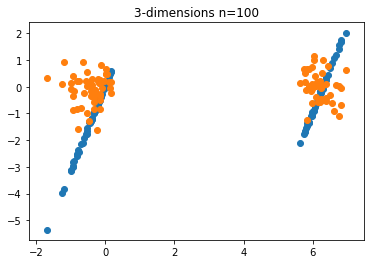

In [158]:
plt.scatter([x[0] for x in pca_transformed], [x[1] for x in pca_transformed]);
plt.scatter([x[0] for x in pca_transformed], [x[2] for x in pca_transformed]);
plt.title('3-dimensions n=' + str(len(pca_transformed)));

In [159]:
pca_components = principal_component_analysis(pca_data, 2)
pca_transformed = transform(pca_data, pca_components)
pca_transformed[:5]

[[6.271134902113677, -0.0659491636403704],
 [-0.9166322877126727, -2.834773131024607],
 [0.16257323366247278, 0.5883480998206554],
 [6.34639727683103, 0.21048505798788408],
 [-0.024315393138832166, -0.09616107980661281]]

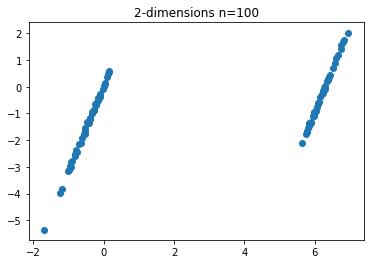

In [160]:
plt.scatter([x[0] for x in pca_transformed], [x[1] for x in pca_transformed]);
plt.title('2-dimensions n=' + str(len(pca_transformed)));

In [161]:
pca_components = principal_component_analysis(pca_data, 1)
pca_transformed = transform(pca_data, pca_components)
pca_transformed[:5]

[[6.271134902113677],
 [-0.9166322877126727],
 [0.16257323366247278],
 [6.34639727683103],
 [-0.024315393138832166]]

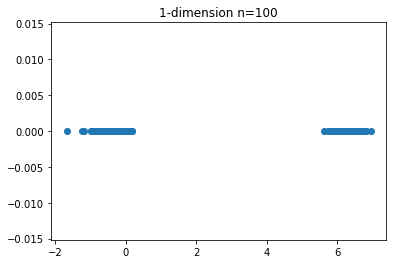

In [162]:
plt.scatter([x[0] for x in pca_transformed], [0 for _ in pca_transformed]);
plt.title('1-dimension n=' + str(len(pca_transformed)));